In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Sample IDs

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]



# Check correlations between types of errors

In [6]:
focal_sample_id = "PD46180c"
chrom = "chr1"

In [19]:
%%time
all_reads = pl.read_parquet(
    Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
        / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.all_reads.parquet"
)

CPU times: user 72.9 ms, sys: 25.2 ms, total: 98 ms
Wall time: 40.6 ms


In [50]:
filtered_all_reads = (all_reads
    .filter(
        (pl.col("mapq1") >= 60) & 
        (pl.col("is_forward1") == pl.col("is_forward2")) &
        (pl.col("total_clipping") <= 10)
    )
)

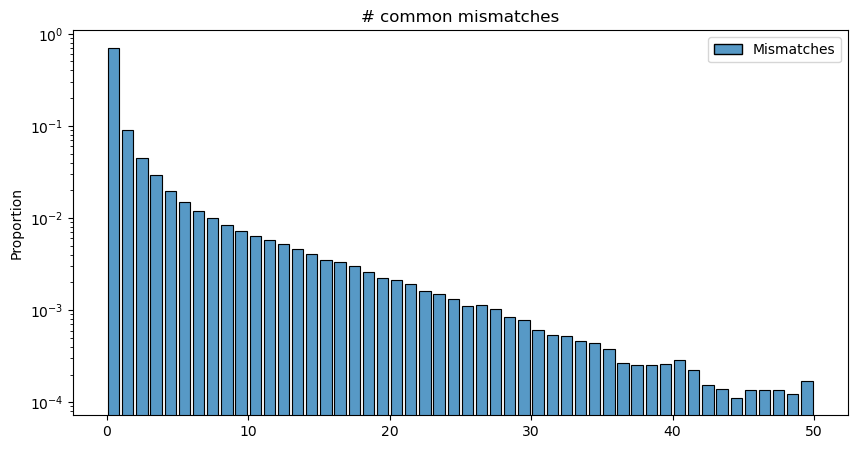

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    [
        pd.Series(filtered_all_reads["total_mismatches"], name="Mismatches"),
    ], 
    bins=np.arange(51),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

ax.set_yscale("log");
ax.set_title("# common mismatches");
#ax.set_ylim(0,0.05);


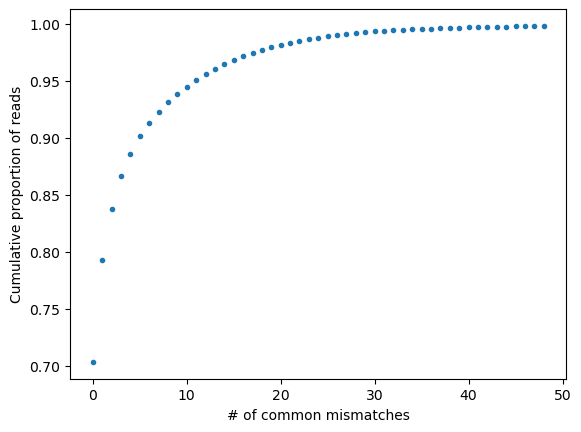

In [56]:
xs = np.arange(50)

plt.plot(
    xs[:-1],
    np.cumsum(
        np.histogram(
            filtered_all_reads["total_mismatches"],
            bins=xs,
        )[0] / len(filtered_all_reads),
    ),
    '.'
)

plt.xlabel("# of common mismatches");
plt.ylabel("Cumulative proportion of reads");

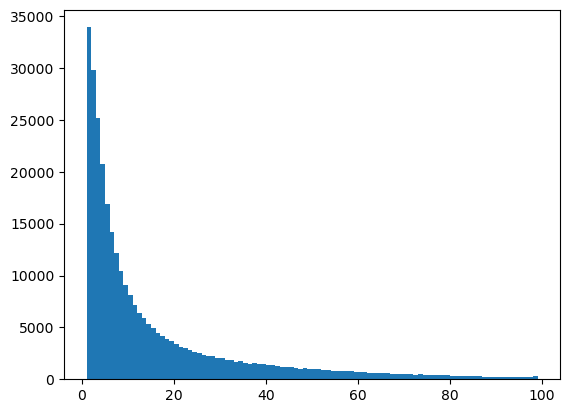

In [25]:
plt.hist(
    all_reads["num_common_deletions"], 
    bins=np.arange(1,100),
    log=False,
);

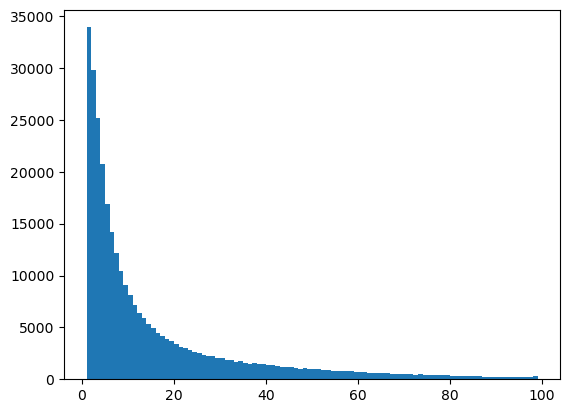

In [26]:
plt.hist(
    all_reads["num_common_deletions"], 
    bins=np.arange(1,100),
    log=False,
);

/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/polars/series/series.py:1476: RuntimeWarning: divide by zero encountered in log10
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


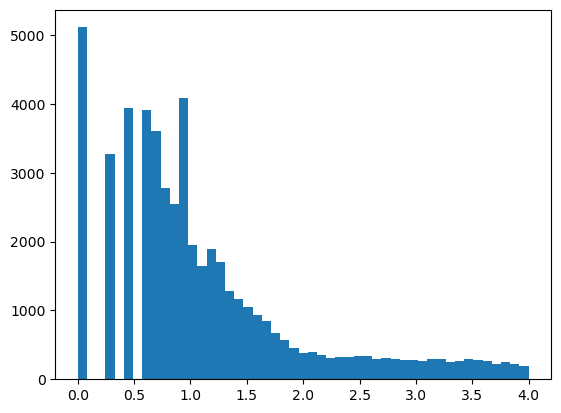

In [27]:
plt.hist(
    np.log10(all_reads["total_clipping"]), 
    bins=np.linspace(0, 4, 50),
    log=False,
);